
# USA Housing Market — End-to-End ML (Revised)
**Synthetic U.S. housing dataset → EDA → Predictive modeling → Prescriptive pricing → Feedback & drift monitoring (robust version)**

This revised notebook:
- Fixes the KS import using `ks_2samp` with a **NumPy fallback** if SciPy is missing
- Guarantees `metrics_df` is created **before** plotting
- Adds **guardrails** and slightly more informative plots (rolling MAE + PSI guide lines)


## 0) Imports & Utilities

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Robust KS import with fallback
try:
    from scipy.stats import ks_2samp as _ks_2samp
    def ks_stat(a, b):
        return float(_ks_2samp(a, b).statistic)
except Exception:
    def ks_stat(a, b):
        a = np.asarray(a); b = np.asarray(b)
        a = a[np.isfinite(a)]; b = b[np.isfinite(b)]
        a.sort(); b.sort()
        na, nb = len(a), len(b)
        ia = ib = 0
        D = 0.0
        while ia < na and ib < nb:
            if a[ia] <= b[ib]:
                x = a[ia]
                while ia < na and a[ia] == x: ia += 1
            else:
                x = b[ib]
                while ib < nb and b[ib] == x: ib += 1
            Fa = ia / na
            Fb = ib / nb
            d = abs(Fa - Fb)
            if d > D: D = d
        D = max(D, abs(1 - ib/nb)) if ia == na else max(D, abs(1 - ia/na))
        return float(D)

def psi(expected, actual, buckets=10):
    e_bins = np.quantile(expected, np.linspace(0,1,buckets+1))
    e_bins = np.unique(e_bins)
    if len(e_bins) <= 2:
        return 0.0
    e_hist, _ = np.histogram(expected, bins=e_bins)
    a_hist, _ = np.histogram(actual, bins=e_bins)
    e_pct = np.clip(e_hist / max(e_hist.sum(),1), 1e-6, None)
    a_pct = np.clip(a_hist / max(a_hist.sum(),1), 1e-6, None)
    return float(np.sum((a_pct - e_pct) * np.log(a_pct / e_pct)))


## 1) Data Generation — U.S. Housing (Synthetic)

In [2]:

rng = np.random.default_rng(2025)

states = [
    ("CA","San Francisco-Oakland-SJ", 37.77, -122.42),
    ("CA","Los Angeles-Long Beach", 34.05, -118.24),
    ("TX","Dallas-Fort Worth", 32.78, -96.8),
    ("TX","Austin-Round Rock", 30.27, -97.74),
    ("FL","Miami-Fort Lauderdale", 25.76, -80.19),
    ("NY","New York-Newark-Jersey", 40.71, -74.01),
    ("IL","Chicago-Naperville", 41.88, -87.63),
    ("WA","Seattle-Tacoma", 47.61, -122.33),
    ("MA","Boston-Cambridge", 42.36, -71.06),
    ("GA","Atlanta-Sandy Springs", 33.75, -84.39),
]
property_types = ["single_family","condo","townhouse"]
n = 12000

def sample_geo(i):
    st, metro, lat, lon = states[i % len(states)]
    lat_j = lat + np.random.normal(0, 0.3)
    lon_j = lon + np.random.normal(0, 0.3)
    zip3 = int(abs((lat_j*100 + lon_j*10)) % 999)
    return st, metro, zip3, lat_j, lon_j

rows = []
for i in range(n):
    st, metro, zip3, lat, lon = sample_geo(i + np.random.randint(0,1000))
    ptype = np.random.choice(property_types, p=[0.6, 0.25, 0.15])
    year_built = int(np.random.randint(1940, 2024))
    age = 2024 - year_built
    sqft = float(np.clip(np.random.normal(2200 if ptype=="single_family" else 1100, 400), 450, 6500))
    beds = int(np.clip(np.random.normal(3.2 if ptype=="single_family" else 2.0, 0.8), 1, 7))
    baths = float(np.clip(np.random.normal(2.2 if ptype=="single_family" else 1.5, 0.6), 1, 5))
    lot = float(np.clip(np.random.normal(6500 if ptype=="single_family" else 0, 3000), 0, 20000))
    garage = int(np.random.rand() < (0.8 if ptype!="condo" else 0.3))
    hoa = float(np.clip(np.random.normal(55 if ptype!="single_family" else 20, 25), 0, 350))
    school = float(np.clip(np.random.normal(7.0, 1.8), 1, 10))
    crime = float(np.clip(np.random.normal(4.0, 1.5), 1, 10))
    walk = float(np.clip(np.random.normal(55, 20), 0, 100))
    month = int(np.random.randint(1,13))
    season = np.sin(2*np.pi*(month-1)/12)
    mortgage = float(np.clip(np.random.normal(6.5, 0.7), 3.0, 10.0))
    unemp = float(np.clip(np.random.normal(4.8, 1.2), 2.0, 9.0))
    inventory = float(np.clip(np.random.normal(2.8, 1.0), 0.5, 8.0))
    dom = float(np.clip(np.random.normal(30 + 10*(inventory-3), 12), 5, 150))
    metro_base = {
        "San Francisco-Oakland-SJ": 950000,
        "Los Angeles-Long Beach":   820000,
        "Seattle-Tacoma":           780000,
        "Boston-Cambridge":         750000,
        "New York-Newark-Jersey":   900000,
        "Chicago-Naperville":       450000,
        "Dallas-Fort Worth":        420000,
        "Austin-Round Rock":        520000,
        "Miami-Fort Lauderdale":    600000,
        "Atlanta-Sandy Springs":    380000,
    }[metro]
    struct = 120*sqft + 8000*beds + 7000*baths + 3*lot + 15000*garage - 1200*age
    hood = 35000*(school-5) - 20000*(crime-5) + 1200*(walk-50)
    macro = -8000*(mortgage-5) - 3000*(unemp-4.5) - 12000*(inventory-3) + 10000*season
    true_value = metro_base + 0.7*struct + 0.6*hood + macro + np.random.normal(0, 25000)
    list_price_strategy = np.random.normal(1.03, 0.03)
    list_price = float(np.clip(true_value * list_price_strategy, 80000, 3_500_000))
    demand_factor = 0.07*(school-5) - 0.05*(crime-5) + 0.001*(walk-50) - 0.04*(mortgage-5) - 0.03*(inventory-3) + 0.04*season
    sold_ratio = np.clip(1.00 + demand_factor + np.random.normal(0, 0.03), 0.9, 1.12)
    sold_price = float(np.clip(list_price * sold_ratio, 80000, 4_000_000))

    rows.append({
        "state": st, "metro": metro, "zip3": zip3, "lat": lat, "lon": lon,
        "property_type": ptype, "year_built": year_built, "age": age,
        "sqft": sqft, "beds": beds, "baths": baths, "lot_sqft": lot,
        "has_garage": garage, "hoa_fee": hoa,
        "school_rating": school, "crime_index": crime, "walk_score": walk,
        "month": month, "season": season,
        "mortgage_rate": mortgage, "unemployment_rate": unemp,
        "months_inventory": inventory, "days_on_market": dom,
        "list_price": list_price, "sold_price": sold_price, "true_value": true_value
    })

df = pd.DataFrame(rows)
df.shape, df.head(3)


((12000, 26),
   state                  metro  zip3        lat        lon  property_type  \
 0    FL  Miami-Fort Lauderdale   824  26.215024 -79.815441  single_family   
 1    TX      Austin-Round Rock    80  30.559571 -97.768702  single_family   
 2    MA       Boston-Cambridge   534  42.414386 -71.023725  single_family   
 
    year_built  age         sqft  beds  ...  walk_score  month    season  \
 0        1959   65  2577.878883     3  ...   17.043335      6  0.500000   
 1        2011   13  2276.678885     2  ...   82.062476      9 -0.866025   
 2        2022    2  2000.336175     3  ...   69.693745      6  0.500000   
 
    mortgage_rate  unemployment_rate  months_inventory  days_on_market  \
 0       5.979846           4.293371          2.541191       33.550255   
 1       7.993938           5.858866          2.144011        8.831279   
 2       6.523416           4.490079          2.258443       43.771766   
 
      list_price    sold_price    true_value  
 0  9.429684e+05  1.0

## 2) EDA — Distributions & Relationships

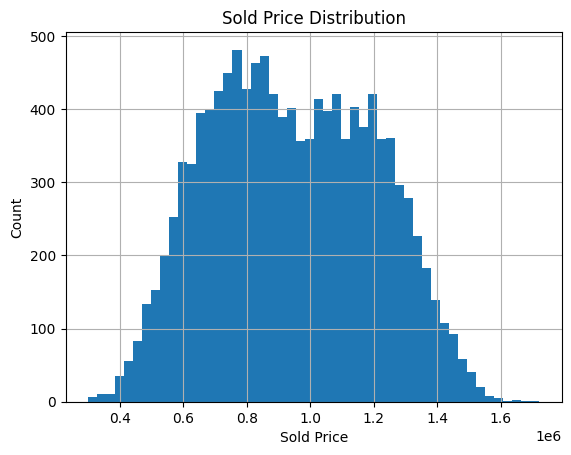

In [3]:

plt.figure()
df["sold_price"].hist(bins=50)
plt.title("Sold Price Distribution")
plt.xlabel("Sold Price"); plt.ylabel("Count")
plt.show()


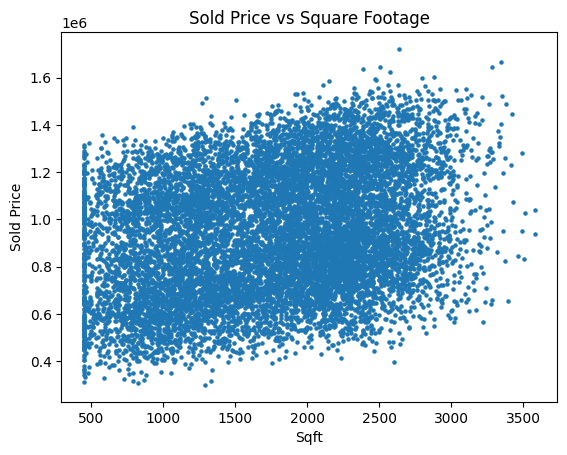

In [4]:

plt.figure()
plt.scatter(df["sqft"], df["sold_price"], s=5)
plt.title("Sold Price vs Square Footage")
plt.xlabel("Sqft"); plt.ylabel("Sold Price")
plt.show()


In [5]:

num_cols = ["sold_price","list_price","sqft","beds","baths","age","hoa_fee","school_rating","crime_index","walk_score","mortgage_rate","unemployment_rate","months_inventory","days_on_market"]
corr = df[num_cols].corr(numeric_only=True)
corr.loc[["sold_price"]].T.sort_values("sold_price", ascending=False).head(12)


,sold_price
sold_price,1.000000
list_price,0.970649
school_rating,0.311762
sqft,0.283679
beds,0.142123
baths,0.137588
walk_score,0.089285
unemployment_rate,-0.010079
days_on_market,-0.042920
mortgage_rate,-0.062687


## 3) Predictive Modeling — Sold Price

In [6]:

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

target = "sold_price"
cat_cols = ["state","metro","property_type"]
num_cols = ["sqft","beds","baths","age","lot_sqft","has_garage","hoa_fee",
            "school_rating","crime_index","walk_score","month","season",
            "mortgage_rate","unemployment_rate","months_inventory","days_on_market","list_price"]

X = df[cat_cols + num_cols]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols),
])

model = Pipeline([
    ("pre", pre),
    ("gb", GradientBoostingRegressor(random_state=42))
])

model.fit(X_train, y_train)
pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)
(mae, r2)


(17961.52202331043, 0.9898711168373515)

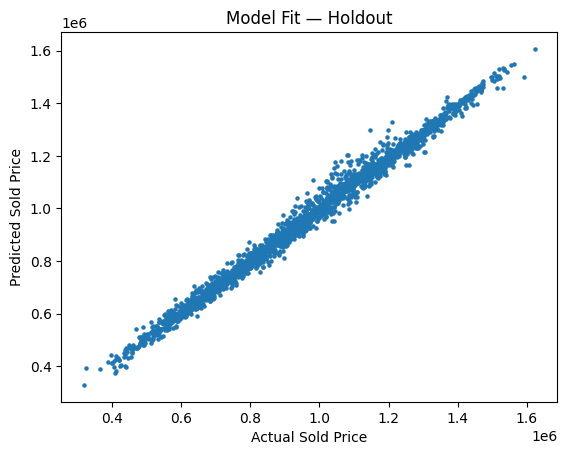

In [7]:

plt.figure()
plt.scatter(y_test, pred, s=5)
plt.xlabel("Actual Sold Price"); plt.ylabel("Predicted Sold Price")
plt.title("Model Fit — Holdout")
plt.show()


## 4) Prescriptive Pricing — Optimize List Price (Grid Search)

In [8]:

sample = df.sample(1, random_state=1).iloc[0]
base = sample.copy()

def predict_sold_for_list(lp, record):
    x = record.copy()
    x["list_price"] = lp
    cols = ["state","metro","property_type","sqft","beds","baths","age","lot_sqft","has_garage","hoa_fee",
            "school_rating","crime_index","walk_score","month","season","mortgage_rate","unemployment_rate","months_inventory","days_on_market","list_price"]
    return float(model.predict(pd.DataFrame([x[cols]]))[0])

lp_grid = np.linspace(base["list_price"]*0.9, base["list_price"]*1.1, 41)
fees = 0.06
pred_sold = np.array([predict_sold_for_list(lp, base) for lp in lp_grid])
net_proceeds = pred_sold * (1 - fees)
best_idx = int(np.argmax(net_proceeds))
best_lp = float(lp_grid[best_idx]); best_sp = float(pred_sold[best_idx]); best_np = float(net_proceeds[best_idx])
(best_lp, best_sp, best_np)


(618449.8748039835, 699294.2160308107, 657336.5630689621)

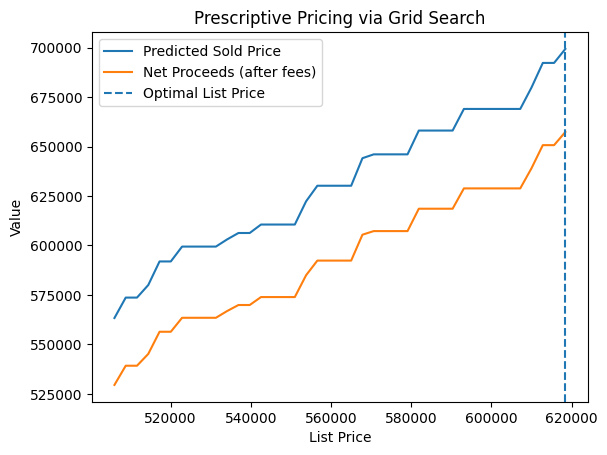

In [9]:

plt.figure()
plt.plot(lp_grid, pred_sold, label="Predicted Sold Price")
plt.plot(lp_grid, net_proceeds, label="Net Proceeds (after fees)")
plt.axvline(best_lp, linestyle="--", label="Optimal List Price")
plt.xlabel("List Price"); plt.ylabel("Value")
plt.title("Prescriptive Pricing via Grid Search")
plt.legend(); plt.show()


## 5) Feedback Loop & Drift — Future Months

In [10]:

history = df.copy()
ref_lp = history["list_price"].values
months_future = 12
metrics = []

for m in range(1, months_future+1):
    drift = df.sample(400, random_state=100+m).copy()
    drift["mortgage_rate"] = np.clip(drift["mortgage_rate"] + 0.12*m, 3.0, 12.0)
    drift["months_inventory"] = np.clip(drift["months_inventory"] + 0.08*m, 0.5, 10.0)
    chosen = []
    for _, row in drift.iterrows():
        base = row.copy()
        grid = np.linspace(base["list_price"]*0.9, base["list_price"]*1.1, 9)
        preds = np.array([predict_sold_for_list(lp, base) for lp in grid])
        npv = preds * (1 - 0.06)
        lp_star = float(grid[int(np.argmax(npv))])
        base["list_price"] = lp_star
        sold_sim = predict_sold_for_list(lp_star, base) + np.random.normal(0, 15000)
        base["sold_price"] = float(np.clip(sold_sim, 80000, 5_000_000))
        chosen.append(base)
    new_batch = pd.DataFrame(chosen)

    Xb = new_batch[["state","metro","property_type","sqft","beds","baths","age","lot_sqft","has_garage","hoa_fee",
                    "school_rating","crime_index","walk_score","month","season","mortgage_rate","unemployment_rate","months_inventory","days_on_market","list_price"]]
    yb = new_batch["sold_price"]
    pb = model.predict(Xb)
    from sklearn.metrics import mean_absolute_error, r2_score
    mae_b = mean_absolute_error(yb, pb); r2_b = r2_score(yb, pb)

    history = pd.concat([history, new_batch], ignore_index=True)
    if m % 3 == 0:
        Xa = history[["state","metro","property_type","sqft","beds","baths","age","lot_sqft","has_garage","hoa_fee",
                      "school_rating","crime_index","walk_score","month","season","mortgage_rate","unemployment_rate","months_inventory","days_on_market","list_price"]]
        ya = history["sold_price"]
        model.fit(Xa, ya)

    psi_lp = psi(ref_lp, new_batch["list_price"].values, buckets=10)
    ks_lp = ks_stat(ref_lp, new_batch["list_price"].values)
    metrics.append({"month": m, "mae": mae_b, "r2": r2_b, "psi_list_price": psi_lp, "ks_list_price": ks_lp})

metrics_df = pd.DataFrame(metrics)
metrics_df.tail()


,month,mae,r2,psi_list_price,ks_list_price
7,8,12010.664994,0.997073,0.231560,0.195917
8,9,11867.479069,0.997085,0.172431,0.152750
9,10,11026.856205,0.997294,0.200890,0.147250
10,11,11086.645216,0.997517,0.280389,0.193167
11,12,11387.194152,0.996981,0.193832,0.144917


## 6) Monitoring Charts (robust)

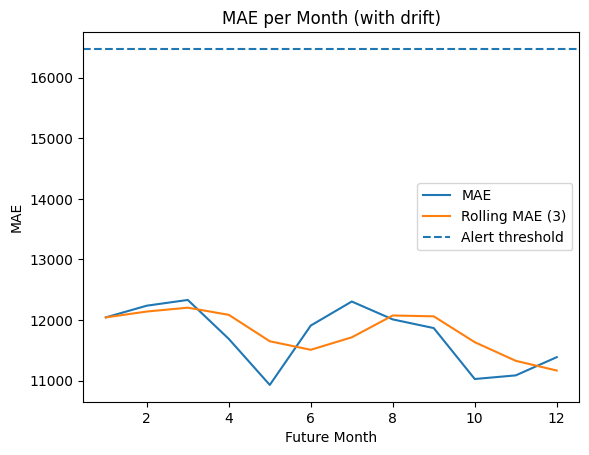

In [11]:

if 'metrics_df' not in locals():
    raise ValueError("Run the feedback-loop cell first to create metrics_df")

plt.figure()
plt.plot(metrics_df["month"], metrics_df["mae"], label="MAE")
roll = metrics_df["mae"].rolling(3, min_periods=1).mean()
plt.plot(metrics_df["month"], roll, label="Rolling MAE (3)")
baseline = metrics_df["mae"].iloc[:min(3, len(metrics_df))].mean()
threshold = baseline * 1.35
plt.axhline(threshold, linestyle="--", label="Alert threshold")
plt.xlabel("Future Month"); plt.ylabel("MAE"); plt.title("MAE per Month (with drift)")
plt.legend(); plt.show()


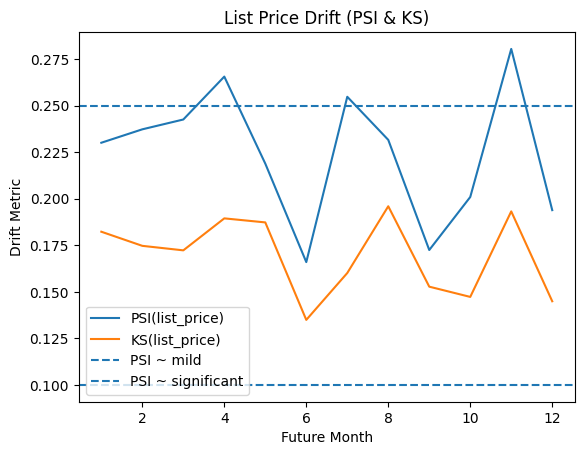

In [12]:

plt.figure()
plt.plot(metrics_df["month"], metrics_df["psi_list_price"], label="PSI(list_price)")
plt.plot(metrics_df["month"], metrics_df["ks_list_price"], label="KS(list_price)")
plt.axhline(0.10, linestyle="--", label="PSI ~ mild")
plt.axhline(0.25, linestyle="--", label="PSI ~ significant")
plt.xlabel("Future Month"); plt.ylabel("Drift Metric"); plt.title("List Price Drift (PSI & KS)")
plt.legend(); plt.show()



## 7) Next Steps
- Try LightGBM/XGBoost for speed/accuracy
- Add geospatial features (distance to CBD/parks/transit)
- Integrate public data (ACS, FHFA HPI, mortgage series) when available
- Replace grid search with constrained continuous optimization
- Productionize: model registry + scheduled retraining + alerts
